In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
cd /content/gdrive/'My Drive'/Diploma/

/content/gdrive/My Drive/Diploma


In [44]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import os
from zipfile import ZipFile
import useful
import warnings
import math
import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
from io import BytesIO
from zipfile import ZipFile
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [45]:
PATH_models = f'/content/gdrive/MyDrive/Diploma/Models/'
PATH_metrics = f'/content/gdrive/MyDrive/Diploma/Metrics/'

In [46]:
def load_metrics(load_path):
    state_dict = torch.load(PATH_metrics + load_path)
    return state_dict['train_losses_list'], state_dict['test_losses_list'], state_dict['global_steps_list']

In [128]:
trl_ry6, tes_ry6, steps_ry6 = load_metrics('base_timm-regnety_006_metrics.pth')
trl_ry4, tes_ry4, steps_ry4 = load_metrics('base_timm-regnety_004_metrics.pth')
trl_ry2, tes_ry2, steps_ry2 = load_metrics('base_timm-regnety_002_metrics.pth')
trl_rx6, tes_rx6, steps_rx6 = load_metrics('base_timm-regnetx_006_metrics.pth')
trl_rx4, tes_rx4, steps_rx4 = load_metrics('base_timm-regnetx_004_metrics.pth')
trl_rx2, tes_rx2, steps_rx2 = load_metrics('base_timm-regnetx_002_metrics.pth')
trl_mn, tes_mn, steps_mn = load_metrics('base_mobilenet_v2_metrics.pth')

In [9]:
trl_ry41, tes_ry41, steps_ry41 = load_metrics('seg_metrics4.pt')
trl_ry42, tes_ry42, steps_ry42 = load_metrics('seg_metrics_checkpoint.pt')
trl_ry43, tes_ry43, steps_ry43 = load_metrics('seg_metrics_130ep.pt')

In [5]:
import pandas as pd

In [129]:
data = pd.DataFrame(
            {'RegnetY-006':{'Train losses': trl_ry6, 'Test losses': tes_ry6, 'Steps':steps_ry6}, 
             'RegnetY-004':{'Train losses': trl_ry4, 'Test losses': tes_ry4, 'Steps':steps_ry4},
             'RegnetY-002':{'Train losses': trl_ry2, 'Test losses': tes_ry2, 'Steps':steps_ry2}, 
             'RegnetX-006':{'Train losses': trl_rx6, 'Test losses': tes_rx6, 'Steps':steps_rx6},
             'RegnetX-004':{'Train losses': trl_rx4, 'Test losses': tes_rx4, 'Steps':steps_rx4},
             'RegnetX-002':{'Train losses': trl_rx2, 'Test losses': tes_rx2, 'Steps':steps_rx2}, 
             'MobileNet-V2':{'Train losses': trl_mn, 'Test losses': tes_mn, 'Steps':steps_mn}
            }
            )

In [10]:
data = pd.DataFrame(
            {
             'RegnetY-004 1':{'Train losses': trl_ry41, 'Test losses': tes_ry41, 'Steps':steps_ry41},
             'RegnetY-004 2':{'Train losses': trl_ry42, 'Test losses': tes_ry42, 'Steps':steps_ry42},
             'RegnetY-004 3':{'Train losses': trl_ry43, 'Test losses': tes_ry43, 'Steps':steps_ry43}
            }
            )

In [67]:
names =['RegnetY-006','RegnetY-004','RegnetY-002', 'RegnetX-006','RegnetX-004','RegnetX-002', 'MobileNet-V2']

In [16]:
names = ['RegnetY-004 1', 'RegnetY-004 2', 'RegnetY-004 3']

In [12]:
def plot_results(name):
    sns.lineplot(x = 'Steps', y = 'Train losses', data=data[name], color='r', lw=3, marker="o")
    sns.lineplot(x = 'Steps', y = 'Test losses', data=data[name], color='g', lw=3, marker="o")
    plt.ylabel("Средняя ошибка")
    plt.xlabel("Итерация")
    plt.title(name)
    plt.legend(labels=['Train losses','Test losses'], facecolor='white')
    plt.show()

In [13]:
plt.rcParams["figure.figsize"] = (20,10)

In [14]:
def plot_results_train(names):
    for name in names:
      sns.lineplot(x = 'Steps', y = 'Train losses', data=data[name], lw=3, marker="o")
    plt.ylabel("Средняя ошибка", fontsize=20)
    plt.xlabel("Итерация", fontsize=20)
    plt.title("Все средние ошибки на тренировочных данных", fontsize=20)
    plt.legend(labels=names, facecolor='white', fontsize=20 )
    plt.show()

def plot_results_test(names):
    for name in names:
      sns.lineplot(x = 'Steps', y = 'Test losses', data=data[name], lw=3, marker="o")
    plt.ylabel("Средняя ошибка", fontsize=20)
    plt.xlabel("Итерация", fontsize=20)
    plt.title("Все средние ошибки на тестовых данных", fontsize=20)
    plt.legend(labels=names, facecolor='white', fontsize=20 )
    plt.show()

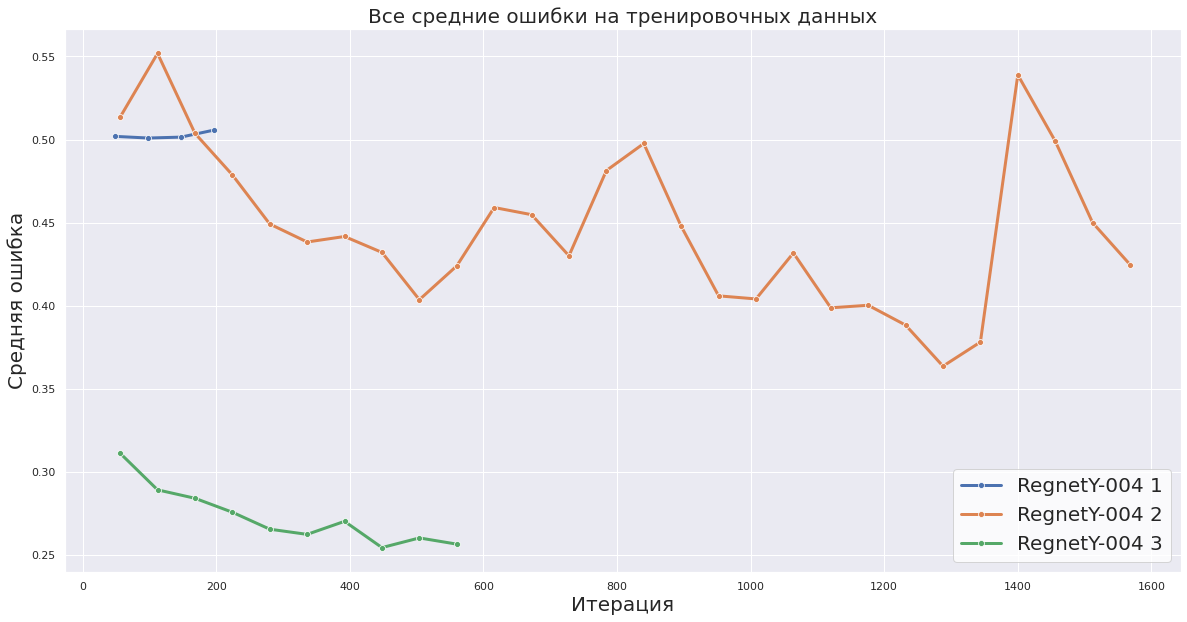

In [17]:
plot_results_train(names)

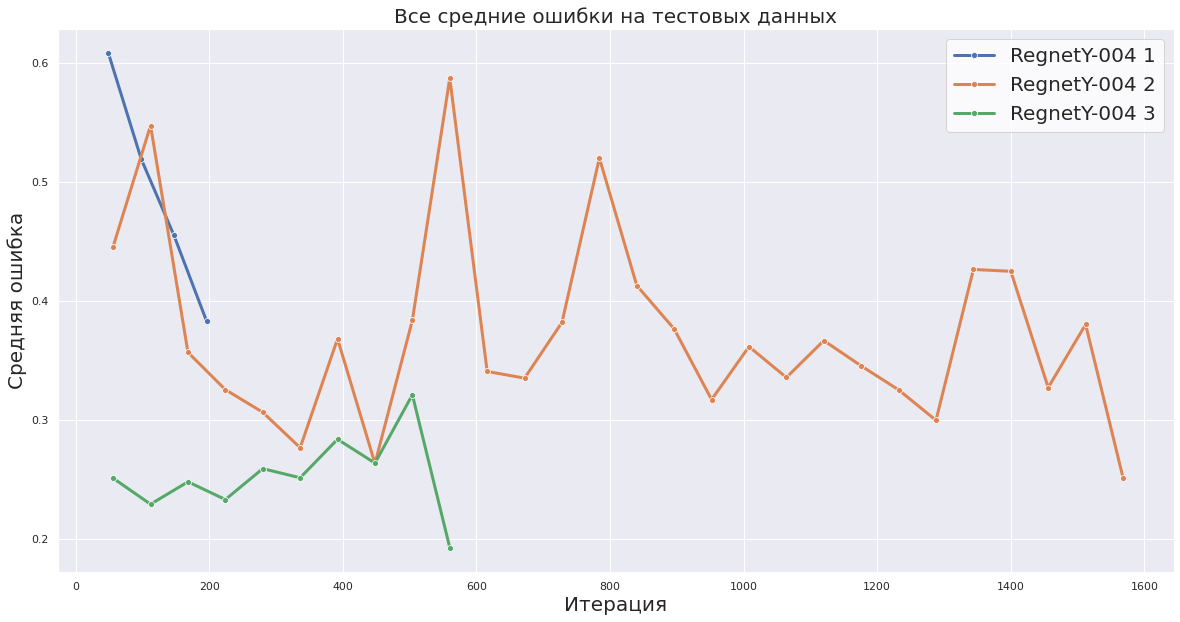

In [18]:
plot_results_test(names)

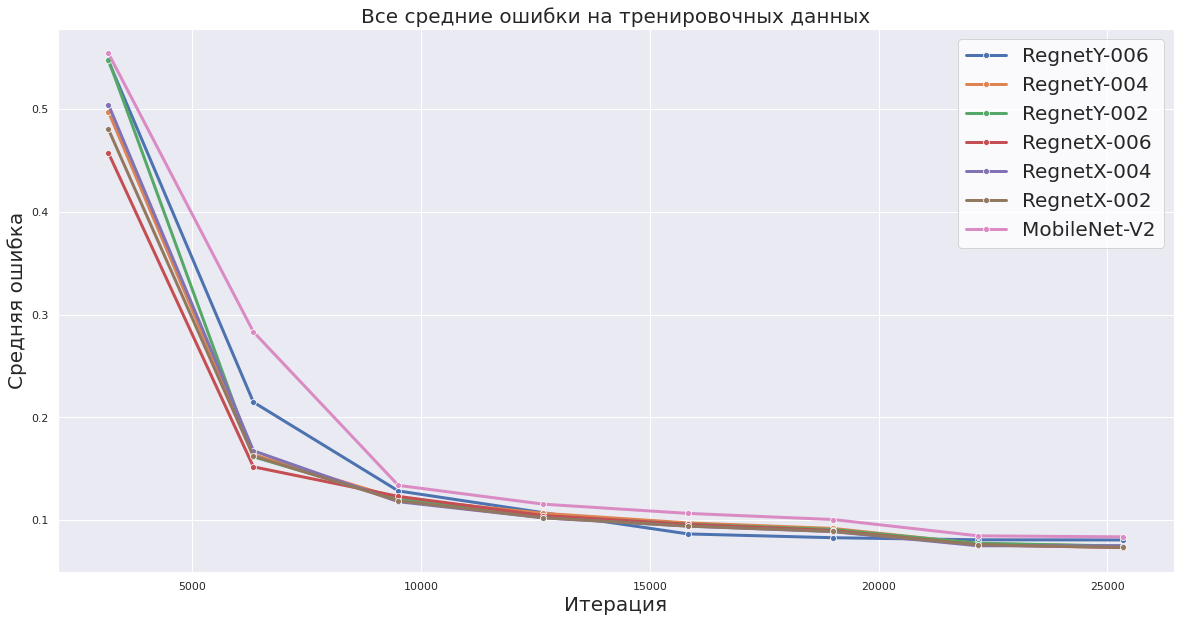

In [131]:
plot_results_train(names)

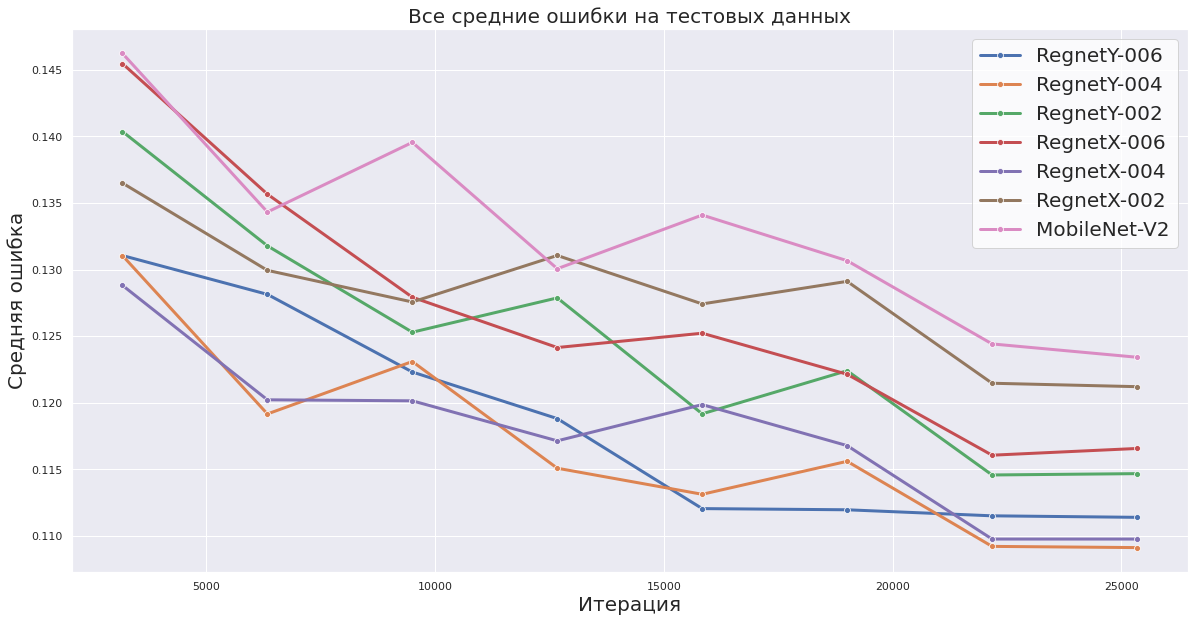

In [132]:
plot_results_test(names)

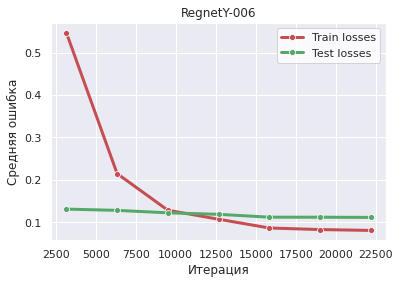

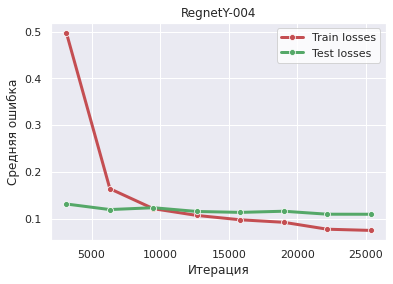

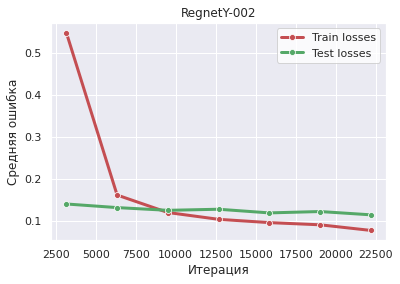

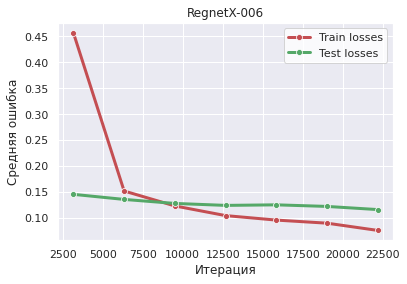

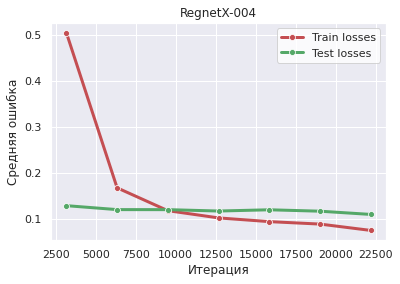

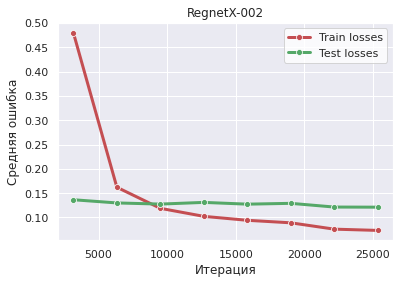

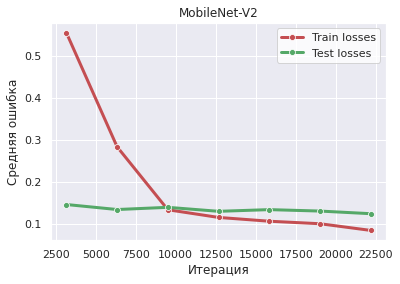

In [73]:
for name in names:
  plot_results(name)

In [48]:
def load_model(model, load_path):
    state_dict = torch.load(PATH_models + load_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()
    return model

In [ ]:
'seg_metrics4.pt')
trl_ry42, tes_ry42, steps_ry42 = load_metrics('seg_metrics_checkpoint.pt')
trl_ry43, tes_ry43, steps_ry43 = load_metrics('seg_metrics_130ep.pt')

In [33]:
seg_models = ['timm-regnety_004', 'timm-regnety_004', 'timm-regnety_004']
models = []
for model in seg_models:
  models.append(smp.Unet(encoder_name=model, 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                ))
model_ry41 = load_model(models[0], 'seg_model4.pt')
model_ry42 = load_model(models[1], 'seg_model_checkpoint.pt')
model_ry43 = load_model(models[2], 'seg_model_130ep.pt')


main_models = {
              'RegnetY-004 1': model_ry41,
               'RegnetY-004 2': model_ry42,
               'RegnetY-004 3': model_ry43
              }

In [49]:
depth_models = ['timm-regnety_006','timm-regnety_004', 'timm-regnety_002', 'timm-regnetx_006', 'timm-regnetx_004', 'timm-regnetx_002', 'mobilenet_v2', 'timm-regnety_004']
models = []
for model in depth_models:
  models.append(smp.Unet(encoder_name=model, 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=1
                ))
model_ry6 = load_model(models[0], 'base_timm-regnety_006_model.pth')
model_ry4 = load_model(models[1], 'base_timm-regnety_004_model.pth')
model_ry2 = load_model(models[2], 'base_timm-regnety_002_model.pth')
model_rx6 = load_model(models[3], 'base_timm-regnetx_006_model.pth')
model_rx4 = load_model(models[4], 'base_timm-regnetx_004_model.pth')
model_rx2 = load_model(models[5], 'base_timm-regnetx_002_model.pth')
model_mn = load_model(models[6], 'base_mobilenet_v2_model.pth')
model_it = load_model(models[7], 'transfer_model.pt')



main_models = {
              'RegnetY-006': model_ry6,
               'RegnetY-004': model_ry4,
               'RegnetY-002': model_ry2,
               'RegnetX-006': model_rx6,
               'RegnetX-004': model_rx4,
               'RegnetX-002': model_rx2,
               'MobileNet-V2': model_mn,
               'Transfered RegnetY-004':model_it
              }

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_006-c67e57ec.pth" to /root/.cache/torch/hub/checkpoints/regnety_006-c67e57ec.pth


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_002-e68ca334.pth" to /root/.cache/torch/hub/checkpoints/regnety_002-e68ca334.pth


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_006-85ec1baa.pth" to /root/.cache/torch/hub/checkpoints/regnetx_006-85ec1baa.pth


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_004-7d0e9424.pth" to /root/.cache/torch/hub/checkpoints/regnetx_004-7d0e9424.pth


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_002-e7e85e5c.pth" to /root/.cache/torch/hub/checkpoints/regnetx_002-e7e85e5c.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
model_ry41

In [ ]:
s = my_predict_segmentaion(model_ry41, Image.open('campus.JPG'))
plt.imshow(s)

In [179]:
len(main_models)

7

In [50]:
def my_predict_segmentaion(model, image, num_classes=40):
  cmap = np.load('SemanticNYU/light-weight-refinenet/utils/cmap.npy')
  image = image.resize((640, 480))
  #plt.imshow(image)
  #plt.show()
  image = np.expand_dims(np.array(image), axis=-1)
  image = image.transpose((3, 2, 0, 1))
  image = torch.from_numpy(image).float()
  #image = image.cuda()
  with torch.no_grad():
    segm = model(image)[0].data.cpu().numpy().transpose(1, 2, 0)
    segm = cv2.resize(segm, (640, 480), interpolation=cv2.INTER_CUBIC)
    segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
  return segm
    

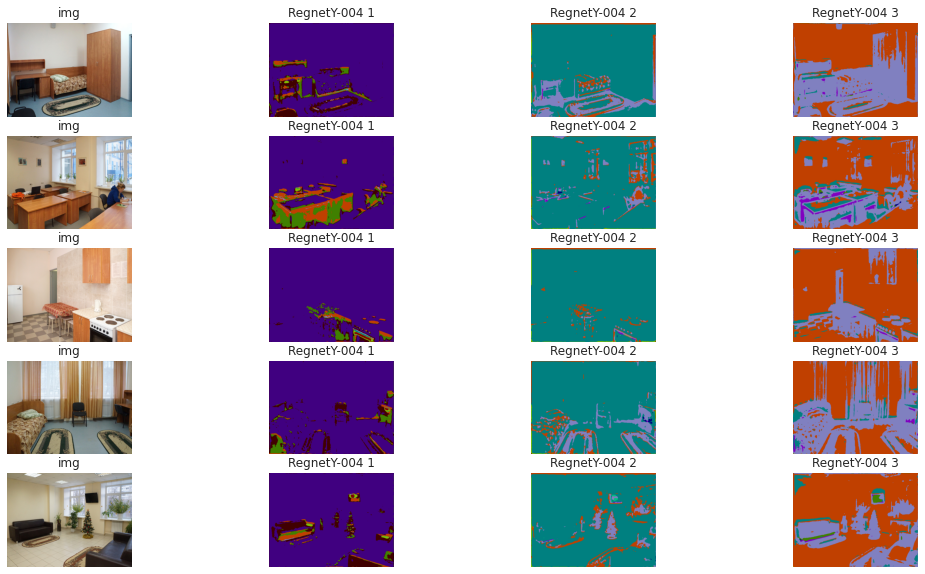

In [42]:
import six
imgs = [Image.open('campus.JPG'), Image.open('campus1.JPG'), Image.open('campus2.JPG'), Image.open('campus3.JPG'), Image.open('campus4.JPG') ]
n_cols = len(models) + 1 
n_rows = len(imgs)

plt.figure(figsize=(18, 10))
idx = 1
for img in imgs:
    plt.subplot(n_rows, n_cols, idx)
    img = img.resize((640, 480))
    plt.imshow(img)
    plt.title('img')
    plt.axis('off')
    idx += 1

    for name, net in six.iteritems(main_models):
            result = my_predict_segmentaion(net, img)
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(result)
            plt.title(name)
            plt.axis('off')
            idx += 1
        

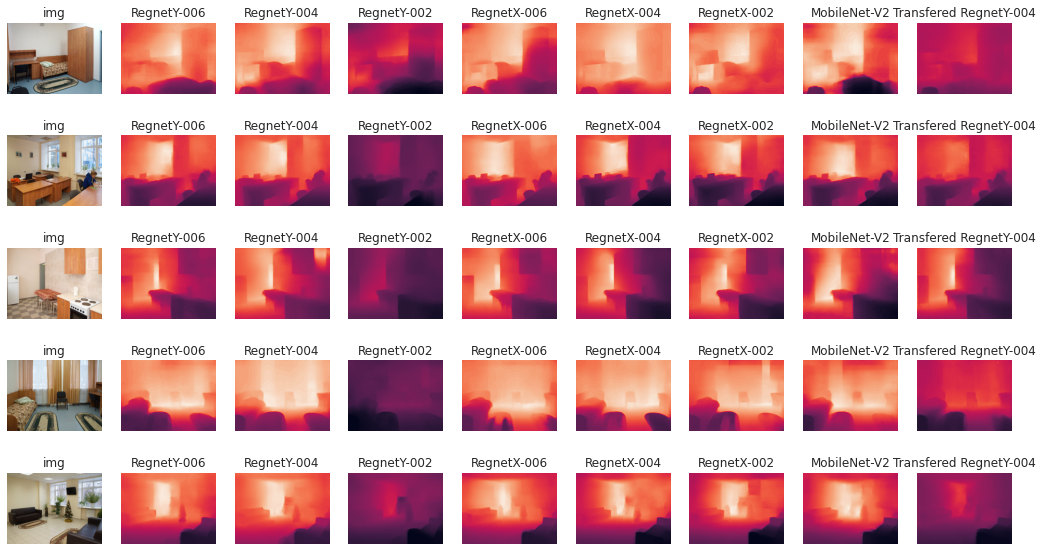

In [53]:
import six
imgs = [Image.open('campus.JPG'), Image.open('campus1.JPG'), Image.open('campus2.JPG'), Image.open('campus3.JPG'), Image.open('campus4.JPG') ]
n_cols = len(models) + 1 
n_rows = len(imgs)

plt.figure(figsize=(18, 10))
idx = 1
for img in imgs:
    plt.subplot(n_rows, n_cols, idx)
    img = img.resize((640, 480))
    plt.imshow(img)
    plt.title('img')
    plt.axis('off')
    idx += 1

    for name, net in six.iteritems(main_models):
            result = my_predict(net, img)
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(result)
            plt.title(name)
            plt.axis('off')
            idx += 1
        

In [170]:
from PIL import Image
image = Image.open('campus1.JPG')
result = my_predict(model_ry4, image)

In [52]:
def my_predict(model, image, minDepth=10, maxDepth=1000):
  image = image.resize((640, 480))
  image = np.expand_dims(np.array(image), axis=-1)
  image = image.transpose((3, 2, 0, 1))
  image = torch.from_numpy(image).float()/255
  #image = image.cuda()
  with torch.no_grad():
    predictions = model(image)
  result = np.clip(useful.normalize_depth(predictions.cpu().numpy(), maxDepth=maxDepth), minDepth, maxDepth) / maxDepth 
  result = result.reshape(480, 640)
  result = Image.fromarray((result*255).astype(np.uint8))
  return result